<a href="https://colab.research.google.com/github/n-n-n/notebooks/blob/main/ncf_dataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


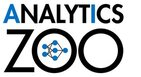
---

## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).

In [1]:
# Install jdk8
! apt-get install openjdk-8-jdk-headless -qq > /dev/null

import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
! update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
! java -version

openjdk version "1.8.0_292"
OpenJDK Runtime Environment (build 1.8.0_292-8u292-b10-0ubuntu1~18.04-b10)
OpenJDK 64-Bit Server VM (build 25.292-b10, mixed mode)


**Install Analytics Zoo**

You can install the latest release version or latest pre-release version using `pip install --pre --upgrade analytics-zoo`. 

In [2]:
# Install latest release version of analytics-zoo 
# Installing analytics-zoo from pip will automatically install pyspark, bigdl, and their dependencies.
! pip install --pre --upgrade analytics-zoo[ray]

Requirement already up-to-date: analytics-zoo[ray] in /usr/local/lib/python3.7/dist-packages (0.11.0b20210630)


## **Using Spark Dataframes for Distribtued Deep Learning** 

In this guide we will describe how to use Spark Dataframes to process large-scale dataset.

#### **Intialization** 

import necessary libraries

In [3]:
import os
import zipfile
import argparse

import numpy as np

from bigdl.dataset import base
from sklearn.model_selection import train_test_split

from zoo.orca import init_orca_context, stop_orca_context
from zoo.orca import OrcaContext
from zoo.orca.learn.tf2 import Estimator
from zoo.orca.data import SharedValue

from pyspark.sql.functions import col
import zoo.orca.data.pandas

Prepending /usr/local/lib/python3.7/dist-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /usr/local/lib/python3.7/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.2-spark_2.4.3-0.11.0-SNAPSHOT-jar-with-dependencies.jar to BIGDL_JARS
Prepending /usr/local/lib/python3.7/dist-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path


## **Init Orca Context** 

In [4]:
# recommended to set it to True when running Analytics Zoo in Jupyter notebook 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

cluster_mode = "local"

if cluster_mode == "local":  
    init_orca_context(cluster_mode="local", cores=4) # run in local mode
elif cluster_mode == "yarn":  
    init_orca_context(cluster_mode="yarn-client", num_nodes=2, cores=2, driver_memory="6g") # run on Hadoop YARN cluster

Initializing orca context
Current pyspark location is : /usr/local/lib/python3.7/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.2-spark_2.4.3-0.11.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/lib/bigdl-0.12.2-jar-with-dependencies.jar pyspark-shell 
2021-06-30 13:42:43 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/lib/python3.7/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.2-spark_2.4.3-0.11.0-SNAPSHOT-jar-with-dependencies.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/lib/python3.7/dist-packages/pyspark/jars/slf4j-log4j12-1.7.16.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


cls.getname: com.intel.analytics.bigdl.python.api.Sample
BigDLBasePickler registering: bigdl.util.common  Sample
cls.getname: com.intel.analytics.bigdl.python.api.EvaluatedResult
BigDLBasePickler registering: bigdl.util.common  EvaluatedResult
cls.getname: com.intel.analytics.bigdl.python.api.JTensor
BigDLBasePickler registering: bigdl.util.common  JTensor
cls.getname: com.intel.analytics.bigdl.python.api.JActivity
Successfully got a SparkContext
BigDLBasePickler registering: bigdl.util.common  JActivity



User settings:

   KMP_AFFINITY=granularity=fine,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   OMP_NUM_THREADS=1

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_HAND_THREAD=false
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_FORKJOIN_FRAMES=true
   KMP_FORKJOIN_FRAMES_MODE=3
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_ITT_PREPARE_DELAY=0
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
  

## **Data Preprocessing with Spark Dataframes**

Orca supports Spark Dataframes as the input to the distributed training, and as the input/output of the distributed inference. Consequently, the user can easily process large-scale dataset using Apache Spark, and directly apply AI models on the distributed (and possibly in-memory) Dataframes without data conversion or serialization.

In [5]:
# Download and extract movielens 1M data.
url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
local_file = base.maybe_download('ml-1m.zip', '.', url)
if not os.path.exists('./ml-1m'):
        zip_ref = zipfile.ZipFile(local_file, 'r')
        zip_ref.extractall('.')
        zip_ref.close()

In [6]:
# Read in the dataset, and do a little preprocessing
rating_files="./ml-1m/ratings.dat"
new_rating_files="./ml-1m/ratings_new.dat"
if not os.path.exists(new_rating_files):
        fin = open(rating_files, "rt")
        fout = open(new_rating_files, "wt")
        for line in fin:
            # replace :: to : for spark 2.4 support
            fout.write(line.replace('::', ':'))
        fin.close()
        fout.close()

In [7]:
# read csv
spark = OrcaContext.get_spark_session()
df = (
    spark
    .read.csv(new_rating_files, sep=':', header=True, inferSchema=True)
    .toDF("user", "item", "label", "timestamp")
)

user_set = df.select('user').collect()
item_set = df.select('item').collect()

min_user_id = min(user_set)[0]
max_user_id = max(user_set)[0]
min_item_id = min(item_set)[0]
max_item_id = max(item_set)[0]
print(min_user_id, max_user_id, min_item_id, max_item_id)

1 6040 1 3952


In [8]:
# update label starting from 0
df = df.withColumn('label', df.label-1)

In [9]:
# split to train/test dataset
train_data, test_data = df.randomSplit([0.8, 0.2], 100)

In [10]:
train_data.printSchema()

root
 |-- user: integer (nullable = true)
 |-- item: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- timestamp: integer (nullable = true)



In [11]:
train_data.count(), test_data.count()

(799608, 200600)

### **Define NCF Model**

In [12]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__, keras.__version__)
def model_creator(config):
    embedding_size=16
    user = keras.layers.Input(dtype=tf.int32, shape=(None,))
    item = keras.layers.Input(dtype=tf.int32, shape=(None,))
    label = keras.layers.Input(dtype=tf.int32, shape=(None,))

    with tf.name_scope("GMF"):
        user_embed_GMF = keras.layers.Embedding(max_user_id + 1, embedding_size)(user)
        item_embed_GMF = keras.layers.Embedding(max_item_id + 1, embedding_size)(item)
        GMF = keras.layers.Multiply()([user_embed_GMF, item_embed_GMF])

    with tf.name_scope("MLP"):
        user_embed_MLP = keras.layers.Embedding(max_user_id + 1, embedding_size)(user)
        item_embed_MLP = keras.layers.Embedding(max_item_id + 1, embedding_size)(item)
        interaction = tf.concat([user_embed_MLP, item_embed_MLP], axis=-1)
        layer1_MLP = keras.layers.Dense(units=embedding_size * 2, activation='relu')(interaction)
        layer1_MLP = keras.layers.Dropout(rate=0.2)(layer1_MLP)
        layer2_MLP = keras.layers.Dense(units=embedding_size, activation='relu')(layer1_MLP)
        layer2_MLP = keras.layers.Dropout(rate=0.2)(layer2_MLP)
        layer3_MLP = keras.layers.Dense(units=embedding_size // 2, activation='relu')(layer2_MLP)
        layer3_MLP = keras.layers.Dropout(rate=0.2)(layer3_MLP)

    # Concate the two parts together
    with tf.name_scope("concatenation"):
        concatenation = tf.concat([GMF, layer3_MLP], axis=-1)
        outputs = keras.layers.Dense(units=5, activation='softmax')(concatenation)
    
    model = keras.Model(inputs=[user, item], outputs=outputs)
    model.compile(optimizer= "adam",
                  loss= "sparse_categorical_crossentropy",
                  metrics=['accuracy'])
    return model

2.5.0 2.5.0


### **Fit with Orca Estimator**

In [13]:
batch_size=1280
epochs=2
model_dir='./'

# create an Estimator
est = Estimator.from_keras(model_creator=model_creator, workers_per_node=1)

stats = est.fit(train_data,
                epochs=epochs,
                batch_size=batch_size,
                feature_cols=['user', 'item'],
                label_cols=['label'],
                steps_per_epoch=800000 // batch_size,
                validation_data=test_data,
                validation_steps = 200000 // batch_size)

checkpoint_path = os.path.join(model_dir, "NCF.ckpt")
est.save(checkpoint_path)

2021-06-30 13:43:21,522	INFO services.py:1174 -- View the Ray dashboard at http://172.28.0.2:8265


{'node_ip_address': '172.28.0.2', 'raylet_ip_address': '172.28.0.2', 'redis_address': '172.28.0.2:6379', 'object_store_address': '/tmp/ray/session_2021-06-30_13-43-20_698221_1732/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2021-06-30_13-43-20_698221_1732/sockets/raylet', 'webui_url': '172.28.0.2:8265', 'session_dir': '/tmp/ray/session_2021-06-30_13-43-20_698221_1732', 'metrics_export_port': 60889, 'node_id': '49c8ac40c338e2340fd9ae995f64e4ec674341b86ffd6c90cb201eb5'}
(pid=2025) Prepending /usr/local/lib/python3.7/dist-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=2025) Prepending /usr/local/lib/python3.7/dist-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path


(pid=2025) 2021-06-30 13:43:25.386469: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
(pid=2025) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/zoo/orca/learn/tf2/tf_runner.py:314: _CollectiveAllReduceStrategyExperimental.__init__ (from tensorflow.python.distribute.collective_all_reduce_strategy) is deprecated and will be removed in a future version.
(pid=2025) Instructions for updating:
(pid=2025) use distribute.MultiWorkerMirroredStrategy instead
(pid=2025) 2021-06-30 13:43:27.078391: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
(pid=2025) 2021-06-30 13:43:27.090523: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=2025) 2021-06-30 13:43:27.090642: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be r

(pid=2026) Prepending /usr/local/lib/python3.7/dist-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=2026) Prepending /usr/local/lib/python3.7/dist-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path


2021-06-30 13:43:57,671	INFO worker.py:655 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379


(pid=2416) Prepending /usr/local/lib/python3.7/dist-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=2416) Prepending /usr/local/lib/python3.7/dist-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path


(pid=2025) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/zoo/orca/learn/tf2/tf_runner.py:191: StrategyBase.experimental_distribute_datasets_from_function (from tensorflow.python.distribute.distribute_lib) is deprecated and will be removed in a future version.
(pid=2025) Instructions for updating:
(pid=2025) rename to distribute_datasets_from_function


(pid=2025) Epoch 1/2


(pid=2025) 2021-06-30 13:43:59.585230: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
(pid=2025) 2021-06-30 13:43:59.585878: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2199995000 Hz


625/625 [==============================] - 12s 13ms/step - loss: 1.3812 - accuracy: 0.3777 - val_loss: 1.2825 - val_accuracy: 0.4189
(pid=2025) Epoch 2/2
210/625 [=========>....................] - ETA: 5s - loss: 1.2938 - accuracy: 0.4115
(pid=2025) 
(pid=2025) 215/625 [=========>....................] - ETA: 4s - loss: 1.2935 - accuracy: 0.4114
272/625 [============>.................]
(pid=2025)  - ETA: 4s - loss: 1.2887 - accuracy: 0.4131
625/625 [==============================] - 8s 13ms/step - loss: 1.2707 - accuracy: 0.4248 - val_loss: 1.2282 - val_accuracy: 0.4498


'./NCF.ckpt'

In [14]:
# evaluate with Estimator
stats = est.evaluate(test_data, 
                     feature_cols=['user', 'item'],
                     label_cols=['label'],
                     num_steps=100000 // batch_size)
est.shutdown()
print(stats)

[Stage 24:>                                                         (0 + 4) / 4]Prepending /usr/local/lib/python3.7/dist-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Prepending /usr/local/lib/python3.7/dist-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
Prepending /usr/local/lib/python3.7/dist-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Prepending /usr/local/lib/python3.7/dist-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path


(pid=2584) Prepending /usr/local/lib/python3.7/dist-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=2584) Prepending /usr/local/lib/python3.7/dist-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path


2021-06-30 13:44:28,455	INFO worker.py:655 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379


78/78 [==============================] - 0s 2ms/step - loss: 1.2396 - accuracy: 0.4423
[{'validation_loss': 1.2396360635757446, 'validation_accuracy': 0.4423076808452606}]


In [15]:
stop_orca_context()

Stopping orca context


2021-06-30 13:44:29,377	ERROR import_thread.py:89 -- ImportThread: Connection closed by server.
2021-06-30 13:44:29,379	ERROR worker.py:919 -- print_logs: Connection closed by server.
2021-06-30 13:44:29,380	ERROR worker.py:1109 -- listen_error_messages_raylet: Connection closed by server.
2021-06-30 13:44:29,380	ERROR worker.py:919 -- print_logs: Connection closed by server.
2021-06-30 13:44:29,380	ERROR import_thread.py:89 -- ImportThread: Connection closed by server.
2021-06-30 13:44:29,381	ERROR worker.py:1109 -- listen_error_messages_raylet: Connection closed by server.
